In [1]:
%run init_notebookspace.py

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\bayes_filter\data


In [2]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

from itertools import chain

import sympy as sp

In [3]:
from src.utils import apply_datetime_format, get_ARlags

### load data

In [4]:
sp500_largest = np.load(os.path.join(DATA_DIR, 'sp500_largest.npy'), allow_pickle=True)
sp500_ticker = ['^GSPC']
df_rets = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), index_col='date').drop('Unnamed: 0', axis=1)

In [5]:
test_len = .2
test_ind = int(len(df_rets) * test_len)
df_rets['test_set'] = [*chain([False] * (len(df_rets) - test_ind), [True] * test_ind)]

df_rets.asfreq = "D"

train = df_rets.join(get_ARlags(df_rets['^GSPC'], 5).iloc[:, 1:]).copy()
test = train[train['test_set'] == True].dropna()
train = train[train['test_set'] == False].dropna()

### arima model simple

In [53]:
mod = ARIMA(train['^GSPC'].values, order=(4,0,4))
res = mod.fit()
res.summary()

C:\Users\LukasGrahl\Documents\GIT\bayes_filter\env_bayes_filter\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  599
Model:                 ARIMA(4, 0, 4)   Log Likelihood                1661.474
Date:                Mon, 20 Mar 2023   AIC                          -3302.947
Time:                        10:51:30   BIC                          -3258.995
Sample:                             0   HQIC                         -3285.836
                                - 599                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.497      0.619      -0.001       0.002
ar.L1         -0.9752      0.182     -5.360      0.000      -1.332      -0.619
ar.L2         -0.2309      0.271     -0.852      0.394      -0.762       0.300
ar.L3         -0.6187      0.219     -2.823      0.005      -1.048      -0.189
ar.L4         -0.5653      0.119     -4.737      0.000      -0.799      -0.331
ma.L1          0.8416      0.180      4.684      0.000       0.489       1.194
ma.L2          0.2122      0.241      0.879      0.379      -0.261       0.685
ma.L3          0.7675      0.186      4.137      0.000       0.404       1.131
ma.L4          0.4699      0.099      4.745      0.000       0.276       0.664
sigma2         0.0002   7.12e-06     32.020      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):              1310.80
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
arma_pred = get_ARMA_forecast(res, test['^GSPC'].values.reshape(len(test),1))

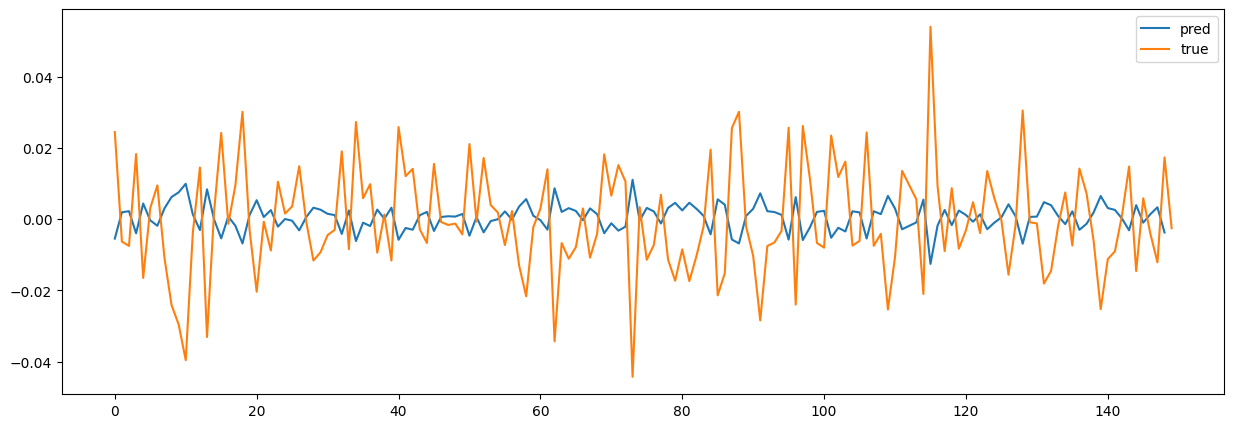

In [61]:
plt.figure(figsize=(15, 5))
plt.plot(arma_pred)
plt.plot(test['^GSPC'].values)
plt.legend(['pred', 'true', 'error'])

### arima model exog

In [113]:
exog = np.zeros((len(train), 1))
exog[:,0] = train['AAPL'].values
# exog[:, 1] = [1] * len(train)

In [114]:
mod = ARIMA(endog=train['^GSPC_lead'].values.reshape(len(train), 1),
            exog=exog,
            order=(2,0,2))
res = mod.fit()

res.summary()

C:\Users\LukasGrahl\Documents\GIT\bayes_filter\env_bayes_filter\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  599
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1644.582
Date:                Mon, 20 Mar 2023   AIC                          -3275.164
Time:                        11:02:09   BIC                          -3244.397
Sample:                             0   HQIC                         -3263.186
                                - 599                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.498      0.618      -0.001       0.002
x1            -0.0316      0.019     -1.630      0.103      -0.070       0.006
ar.L1         -0.3493      0.271     -1.288      0.198      -0.881       0.182
ar.L2         -0.0315      0.188     -0.168      0.867      -0.399       0.336
ma.L1          0.1357      0.273      0.496      0.620      -0.400       0.672
ma.L2          0.1634      0.133      1.228      0.219      -0.097       0.424
sigma2         0.0002   7.02e-06     34.383      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              2800.35
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
def get_ARMA_forecast(arma_res, endog: np.array, exog=None) -> np.array:
    assert len(endog) > 1, f"out_of_sample data needs to be a 2dim np.array"
    if exog is not None: assert len(exog) > 1, f"out_of_sample data needs to be a 2dim np.array"
    if exog is not None: assert len(exog) == len(endog), "endog and exog must have same lenght dimensions"
    
    forecast_out = []
    
    for i in range(0, len(endog)-1):
        if exog is not None:
            arma_res = arma_res.apply(endog=endog[i], exog=exog[i])
        else:
            arma_res = arma_res.apply(endog=endog[i])
            
        forecast_out.append(arma_res.forecast())
    return np.array(forecast_out)

In [116]:
# get_ARMA_forecast(res, endog=test['^GSPC_lead'].values.reshape(len(test), 1),
#                   exog=test['AAPL'].values.reshape(len(test), 1))

In [117]:
# plt.figure(figsize=(15, 5))
# plt.plot(arma_pred)
# plt.plot(df_rets.iloc[:-test_ind]['^GSPC'].values)
# # plt.plot(arma_pred.values - df_rets.iloc[:-test_ind]['^GSPC'].values)
# plt.legend(['pred', 'true', 'error'])

### designing a Kalman Filter

The below ARMA(2,2) process can be described as a state space equation
$$ x_t = c + \phi_1 x_{t-1} + \phi_2 x_{t-2} + \theta_1 u_{t-1} + \theta_2 u_{t-2} + \beta_1 a_{t-1} + u_t $$

In [118]:
syms = sp.symbols([*chain([f'x_{{t-{item}}}' for item in range(0, 3)], # endogs
                          [f'{item}_{{t}}' for item in ['a']], # exogs
                          [f'{item}_{{t-1}}' for item in ['a']], # exogs
                          [f'phi_{item}' for item in range(1, 4)], # endogs params
                          [f'beta_{item}' for item in range(1, 2)], # endogs params
                          ['theta_1', 'theta_2', 'u_{t-1}', 'u_{t-2}', 'u_t']
                          )])
x0, x1, x2, a, a1, phi1, phi2, phi3, beta1, theta1, theta2, u1, u2, u = syms

In [119]:
# state space at t
X = sp.Matrix([x0, x1, u, u1, a])

# state space at t-1
X1 = sp.Matrix([x1, x2, u1, u2, a1])

# state space transition matrix
T = sp.Matrix(
    [
        [phi1, phi2, theta1, theta2, beta1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1]
    ]
)

# additive terms in state space
R = sp.Matrix([1, 0, 1, 0, 0])
# error term at t
U = sp.Matrix([u])

# measurments
measure = sp.Matrix([x0, x1, u1, a1])
# measurement matrix -> translating measurements into state space
Z = sp.Matrix([[1, 0, 0, 0, 0],
               [0, 1, 0, 0, 0],
               [0, 0, 0, 1, 0],
               [0, 0, 0, 0, 1]])

In [120]:
state_space = sp.Eq(X, T @ X1 + R @ U)
state_space

Eq(Matrix([
[x_{t-0}],
[x_{t-1}],
[    u_t],
[u_{t-1}],
[  a_{t}]]), Matrix([
[a_{t-1}*beta_1 + phi_1*x_{t-1} + phi_2*x_{t-2} + theta_1*u_{t-1} + theta_2*u_{t-2} + u_t],
[                                                                                 x_{t-1}],
[                                                                                     u_t],
[                                                                                 u_{t-1}],
[                                                                                 a_{t-1}]]))

In [121]:
T_lamb = sp.lambdify([beta1, phi1, phi2, theta1, theta2], T)

### Kalman filter

In [122]:
from filterpy.common import Q_continuous_white_noise
from sklearn.datasets import make_spd_matrix

In [126]:
from pypfopt.risk_models import CovarianceShrinkage

xdim = 5
zdim = 4

# state space transition matrix
T = T_lamb(*list(res.params[1:-1]))

# process noise matrix
# some semidefinite matrix
Q = make_spd_matrix(5)
# covariance matrix based on train corrected for outliers
Q = CovarianceShrinkage(train[['AAPL', '^GSPC_lead', '^GSPC', '^GSPC_lag_1', '^GSPC_lag_2']], returns_data=True, log_returns=True).ledoit_wolf().values
# covariance matrix based on train not corrected for outliers
# Q = np.cov(np.vstack([train[item].values for item in ['AAPL', '^GSPC_lead', '^GSPC', '^GSPC_lag_1', '^GSPC_lag_2']]))

# measurement noise
H = np.diag([.01] * zdim)
# measurement function: measurement -> state space
Z = np.array(Z, dtype=int)


x0 = np.zeros([5]) + .1
x0 = x0.reshape(xdim, 1)
P0 = np.diag([.1] * 5)

In [127]:
ar = test[['^GSPC', '^GSPC_lag_1']].copy()
a_t = test['AAPL'].loc[ar.index]
assert len(a_t) == len(ar)

zs = np.zeros((len(a_t), zdim, 1))
zs[:, 0:2] = np.expand_dims(ar.values, axis=2)
zs[:, -1] = np.expand_dims(a_t.values, axis=1)

In [128]:
from filterpy.kalman import KalmanFilter

In [129]:
kfilter = KalmanFilter(xdim, zdim)
kfilter.F = T
kfilter.Q = Q
kfilter.H = Z
kfilter.R = H

# set starting values
kfilter.x = x0
kfilter.P = P0
z0 = np.array([.1, .1, 0, .1]).reshape(4, 1)

In [130]:
i = 1
X_out, X_pred, P_out, P_pred, LL_out = [], [], [], [], []

z = z0.copy()

for i in range(0, len(zs)-1):
   
    kfilter.predict()
    X_pred.append(kfilter.x)
    P_pred.append(kfilter.P)
    
    kfilter.update(z)

    # update moving MA(1) in measurment for i+1
    zs[i+1, 2] =  zs[i+1, 0] - kfilter.x[0]
    z = zs[i+1]  
    
    X_out.append(kfilter.x)
    P_out.append(kfilter.P)
    LL_out.append(kfilter.log_likelihood)
    
X_out = np.array(X_out)
P_out = np.array(P_out)
X_pred = np.array(X_pred)
P_pred = np.array(P_pred)
LL_out = np.array(LL_out)

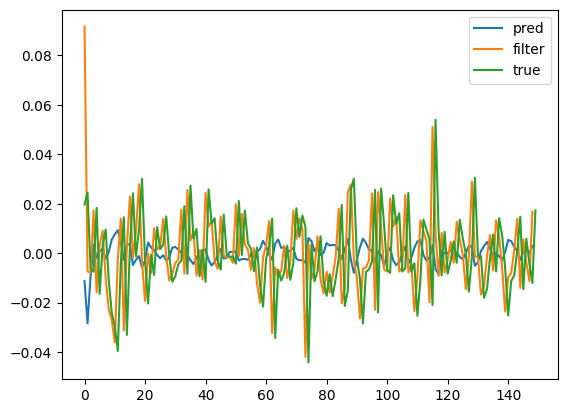

In [131]:
inds, inde = 0, 150
plt.plot(X_pred[inds:inde, 0])
plt.plot(X_out[inds:inde, 0])
plt.plot(test['^GSPC_lead'].values[inds:inde])
plt.legend(['pred', 'filter', 'true'])